# Market breadth predictions with N-BEATS

In [3]:
%pip install -U torch torchvision
%pip install -qU numpy==2.2.0 darts scipy matplotlib requests scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Final model with covariates total_volume and MAs

- Uses 500 epochs (which seems to provide a better fit). Adjust as necessary when running locally
-  

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 9.2 M  | train
-------------------------------------------------------------
9.2 M     Trainable params
3.7 K     Non-trainable params
9.2 M     Total params
36.669    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MP

Epoch 499: 100%|██████████| 23/23 [00:03<00:00,  6.29it/s, train_loss=0.00191] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 23/23 [00:03<00:00,  6.28it/s, train_loss=0.00191]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.87it/s]
SMAPE on validation set: 46.043385


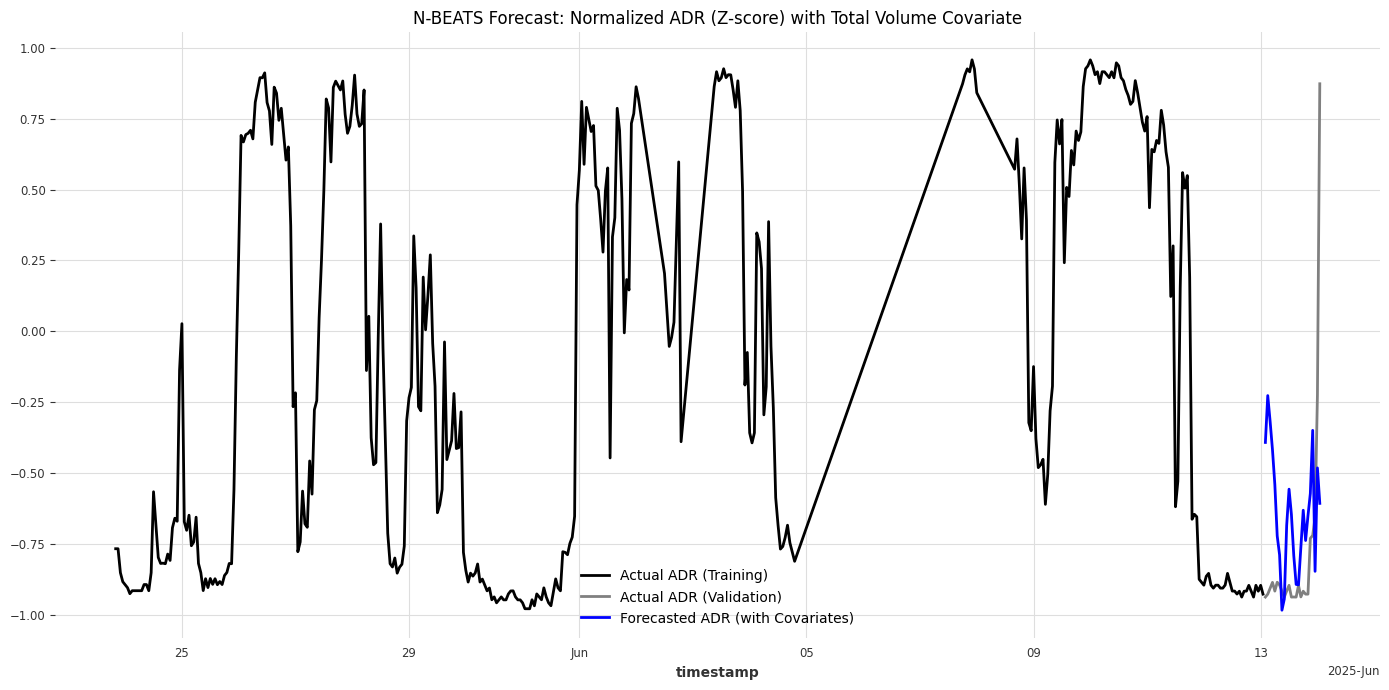

In [13]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import smape
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Fetch data (same as before)
# Fetch data (production endpoint)
url = "https://api.terminal.binbot.in/charts/adr-series?size=400"
data = requests.get(url).json()
df = pd.DataFrame(data["data"])

# Clean and preprocess
# Use only columns required for inference
# (Assumes columns: timestamp, advancers, decliners, total_volume)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
# Round timestamps to the nearest hour
df["timestamp"] = df["timestamp"].dt.floor("h")

# Clean up missing values
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep="last")]

# Feature engineering
df["advancers"] = df["advancers"].astype("float32")
df["decliners"] = df["decliners"].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")
df["adp"] = df["adp"].astype("float32")
df["adp_ma"] = df["adp_ma"].astype("float32")

# Add moving averages if required by the model
df["adp_ma7"] = df["adp"].rolling(7).mean().astype("float32")

df.dropna(inplace=True)

# Convert to Darts TimeSeries (let Darts infer frequency)
series = TimeSeries.from_dataframe(df, value_cols=["adp"], fill_missing_dates=True, freq="h")
covariate_series = TimeSeries.from_dataframe(
    df,
    value_cols=["total_volume", "adp_ma", "adp_ma7"],
    fill_missing_dates=True, freq="h"
)

# Fill missing values for both series and covariate series
filler = MissingValuesFiller()
series_filled = filler.transform(series, method="linear")
covariate_series_filled = filler.transform(covariate_series, method="linear")

# Z-score normalization for both series and covariate series
scaler_series = Scaler()
scaler_covariate = Scaler()
series_scaled = scaler_series.fit_transform(series_filled)
covariate_series_scaled = scaler_covariate.fit_transform(covariate_series_filled)

# Parameters
input_chunk_length = 100
forecast_horizon = 24

# Train/validation split for both series and covariate series
train_scaled, val_scaled = (
    series_scaled[:-forecast_horizon],
    series_scaled[-forecast_horizon:],
)
train_orig, val_orig = (
    series_filled[:-forecast_horizon],
    series_filled[-forecast_horizon:],
)
train_covariate_scaled = covariate_series_scaled[:-forecast_horizon]

# Define N-BEATS model with future covariates
model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    n_epochs=500,
    batch_size=16,
    random_state=42,
    optimizer_cls=optim.AdamW,
    optimizer_kwargs={"lr": 1e-4},
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={"patience": 15, "factor": 0.5, "monitor": "train_loss"},
)

# Fit model with future covariates
model.fit(train_scaled, past_covariates=covariate_series_scaled, verbose=True)

# Forecast beyond training data using the last available covariate window
future_covariates = covariate_series_scaled[
    -(input_chunk_length + forecast_horizon) :
]

future_forecast_scaled = model.predict(
    n=forecast_horizon, past_covariates=future_covariates
)

# Convert forecast to original scale
future_forecast_orig = scaler_series.inverse_transform(future_forecast_scaled)

# Extract the corresponding portion of actual series for validation
val_orig = series_filled[-forecast_horizon:]

# Evaluation (using the original scale validation data)
print("SMAPE on validation set:", smape(val_orig, future_forecast_orig))

# Plot
plt.figure(figsize=(14, 7))

# Plot actual normalized ADR for training and validation periods
train_orig.plot(label="Actual ADR (Training)", lw=2, color="black")
val_orig.plot(label="Actual ADR (Validation)", lw=2, color="gray")

# Plot forecast extending from the end of the training data
future_forecast_orig.plot(label="Forecasted ADR (with Covariates)", lw=2, color="blue")

model.save("../dist/market_breadth_nbeats_model_v1.pth")

plt.title("N-BEATS Forecast: Normalized ADR (Z-score) with Total Volume Covariate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Production Inference: Predict Market Breadth with N-BEATS

This notebook cell is for production use only. It loads a pre-trained N-BEATS model, preprocesses new data, and outputs the latest forecast. All training and experimentation code has been removed.

- Load model
- Preprocess data
- Predict
- Output results

In [ ]:
# Production prediction script for N-BEATS model with covariates
import pandas as pd
import requests
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import NBEATSModel

# Load the saved model
model = NBEATSModel.load("../dist/market_breadth_nbeats_model_v1.pth")

# Fetch data (production endpoint)
url = "https://api.terminal.binbot.in/charts/adr-series?size=700"
data = requests.get(url).json()
df = pd.DataFrame(data["data"])

# Clean and preprocess
# Use only columns required for inference
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
# Floor all timestamps to the nearest hour to match model training
df["timestamp"] = df["timestamp"].dt.floor("h")
# Clean up missing values
df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
if df.isnull().values.any():
    df = df.interpolate()
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)
# Remove duplicate timestamps, keeping the last occurrence
df = df[~df.index.duplicated(keep='last')]

# Feature engineering
df["diff"] = (df["advancers"] - df["decliners"]).astype("float32")
df["advancers"] = df["advancers"].astype("float32")
df["decliners"] = df["decliners"].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Calculate normalized AD diff
df["adp"] = (df["diff"] / (df["advancers"] + df["decliners"])).astype("float32")

# Add moving averages if required by the model
df["adp_ma"] = df["adp_ma"].astype("float32")
df["adp_ma7"] = (df["adp"].rolling(7).mean()).astype("float32")

df.dropna(inplace=True)

# --- Extend covariates into the future ---
input_chunk_length = 240
forecast_horizon = 72

# Create a future index for the forecast horizon
last_timestamp = df.index[-1]
future_index = pd.date_range(start=last_timestamp + pd.Timedelta(1, unit='h'), periods=forecast_horizon, freq="h")

# Forward-fill the last row for covariates
future_covariates_df = pd.DataFrame(
    [df.iloc[-1][["total_volume", "adp_ma", "adp_ma7"]].values] * forecast_horizon,
    columns=["total_volume", "adp_ma", "adp_ma7"],
    index=future_index
)

# Append to the original DataFrame for covariates
covariate_df_full = pd.concat([
    df[["total_volume", "adp_ma", "adp_ma7"]],
    future_covariates_df
])

# Create TimeSeries for target and covariates
covariate_series = TimeSeries.from_dataframe(
    covariate_df_full,
    value_cols=["total_volume", "adp_ma", "adp_ma7"],
    fill_missing_dates=True, freq="h"
)

# Fill missing values
filler = MissingValuesFiller()
covariate_series_filled = filler.transform(covariate_series, method="linear")

# Z-score normalization (fit on all available data)
scaler_series = Scaler()
scaler_covariate = Scaler()

# Fit scaler_series on the target series (adp)
series_for_scaling = TimeSeries.from_dataframe(df, value_cols=["adp"], fill_missing_dates=True, freq="h")
series_for_scaling_filled = filler.transform(series_for_scaling, method="linear")
scaler_series.fit(series_for_scaling_filled)

covariate_series_scaled = scaler_covariate.fit_transform(covariate_series_filled)

# Use the latest available covariates for prediction
future_covariates = covariate_series_scaled[-(input_chunk_length + forecast_horizon):]

# Predict
y_pred_scaled = model.predict(n=forecast_horizon, past_covariates=future_covariates)
y_pred = scaler_series.inverse_transform(y_pred_scaled)

# Output forecast as DataFrame
forecast_df = y_pred.to_dataframe()
latest_prediction = forecast_df.iloc[-1]["adp"]
print("Latest forecasted adp:", latest_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/carkod/binbot-notebooks/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]

ValueError: fit() must have been called before inverse_transform()


ValueError: fit() must have been called before inverse_transform()